Processing station: baimasi
Processing station: changjiangtun
Processing station: dalai
Processing station: fuyu
Processing station: heishiguan
Processing station: huaibin
Processing station: humaqiao
Processing station: jiamusi
Processing station: jiangjiaji
Processing station: kuerbin
Processing station: lianhua
Processing station: liujiatun
Processing station: longmenzhen
Processing station: luanxian
Processing station: shihuiyao
Processing station: shuanghetun
Processing station: tangmazhai
Processing station: tieling
Processing station: tonghe
Processing station: tonghua
Processing station: xingjiawopeng
df_q83:
             date      width           Q           83Q      stationid
0     2001-03-30  15.576735    9.600000  2.821633e-04        baimasi
1     2001-03-31   1.198207    3.700000  3.019825e-07        baimasi
2     2001-06-27  14.378485   15.400000  2.279284e-04        baimasi
3     2001-07-04  20.369536   16.000000  5.770052e-04        baimasi
4     2001-09-06  26.360576  

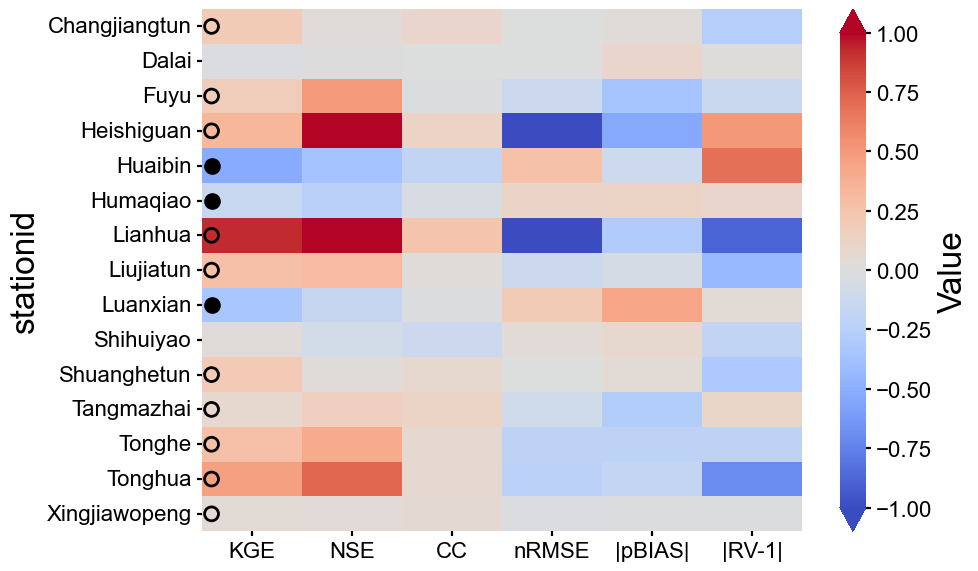

0.13116792455698806
0.9148480046362788
0.03285834467271736
-0.21216272255306864
-0.0820560513701131
-0.1139771870714361
11
11
9
11
9
9
      KGE     NSE    nRMSE     CC   pBIAS      RV  |pBIAS|  |RV-1|  \
2  17.77%  49.22%  -13.07% -1.44%  40.28%  14.05%  -35.86% -14.05%   
6  92.27% 725.49% -179.99% 25.26% -80.08% -88.85%  -29.07% -88.85%   
7  27.61%  30.72%  -12.51%  1.79%   5.48%  43.21%   -5.48% -43.21%   
12 27.50%  41.39%  -21.30%  6.48%  21.41%  21.17%  -21.41% -21.17%   
13 46.61%  72.44%  -23.35%  6.81%  17.27%  70.08%  -17.27% -70.08%   
14  4.46%   3.27%   -1.85%  6.00%   1.04%   1.08%   -1.04%  -1.08%   

        stationid  
2            Fuyu  
6         Lianhua  
7       Liujiatun  
12         Tonghe  
13        Tonghua  
14  Xingjiawopeng  
      KGE     NSE  nRMSE     CC   pBIAS     RV  |pBIAS|  |RV-1| stationid
5 -15.21% -23.44% 11.31% -4.52% -12.22% -9.69%   12.22%   9.69%  Humaqiao
8 -34.07% -16.31% 20.18% -0.90%  44.34% -4.41%   44.34%   4.41%  Luanxian
      KGE   

NameError: name 'w83_df' is not defined

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# ============== 指标计算函数 ==============
def KGE(y_true, y_pred):
    """Kling-Gupta Efficiency (improved 2012)"""
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = (np.std(y_pred) / np.mean(y_pred)) / (np.std(y_true) / np.mean(y_true))
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((correlation - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def NSE(observed, simulated):
    """Nash-Sutcliffe Efficiency"""
    return 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)

def nRMSE(observed, simulated):
    """Normalized Root Mean Square Error"""
    rmse = np.sqrt(mean_squared_error(observed, simulated))
    return rmse / np.mean(observed)

def CC(observed, simulated):
    """Correlation Coefficient (Pearson)"""
    return pearsonr(observed, simulated)[0]

def calculate_metrics(observed, simulated):
    """计算所有指标的统一函数"""
    return {
        'CC': CC(observed, simulated),
        'nRMSE': nRMSE(observed, simulated),
        'KGE': KGE(observed, simulated),
        'NSE': NSE(observed, simulated),
        'pBIAS': simulated.mean() / observed.mean() - 1,
        'RV': (simulated.std() / simulated.mean()) / (observed.std() / observed.mean())
    }

def calculate_station_metrics(df, station_col, observed_col, simulated_col):
    """按站点计算所有指标"""
    results = []
    stations = df[station_col].unique()
    
    for station in stations:
        station_data = df[df[station_col] == station]
        observed = station_data[observed_col]
        simulated = station_data[simulated_col]
        
        metrics = calculate_metrics(observed, simulated)
        metrics['stationid'] = station
        results.append(metrics)
    
    return pd.DataFrame(results)

def compute_stats(df, name):
    """计算统计汇总"""
    total = len(df)
    return {
        'method': name,
        'KGE>0': (df['KGE'] > 0).sum() / total,
        'NSE>0': (df['NSE'] > 0).sum() / total,
        '|pBIAS|<0.5': (df['pBIAS'].abs() < 0.5).sum() / total,
        '|RV-1|<0.5': ((df['RV'] - 1).abs() < 0.5).sum() / total,
        'NRMSE<0.6': (df['nRMSE'] < 0.6).sum() / total,
        'CC>0.5': (df['CC'] > 0.5).sum() / total,
        'NRMSE_median': df['nRMSE'].median(),
        'NRMSE_mean': df['nRMSE'].mean(),
    }

# ============== 主程序 ==============
def main():
    # 读取数据
    df_q50 = pd.read_csv('./2-preprocess/4.q50_weighted_slope.csv')
    folder_path = '/home/xj/device5/202411-SWAP/northchina/landsat/4-validation/observation'
    
    # ============== W83方法计算 ==============
    results = []
    df_q83 = pd.DataFrame()
    
    stations = df_q50['stationid'].unique()
    for station in stations:
        print(f"Processing station: {station}")
        file_match = glob.glob(os.path.join(folder_path, f"*{station}*.csv"))
        if not file_match:
            print(f"File for station {station} not found. Skipping...")
            continue
        
        file_path = file_match[0]
        df_L8 = pd.read_csv(file_path).dropna(subset=['Q'])[['date', 'correct_maxRiverWidth', 'Q']]
        df_L8 = df_L8.rename(columns={'correct_maxRiverWidth': 'width'})
        
        q50 = df_q50.loc[df_q50['stationid'] == station, 'q50_weighted'].values[0]
        w_mean = df_L8['width'].median()
        a = q50 / (w_mean ** (8.0 / 3.0))
        df_L8['83Q'] = a * df_L8['width'] ** (8.0 / 3.0)
        df_L8['stationid'] = station
        df_q83 = pd.concat([df_q83, df_L8], ignore_index=True)
        
        # 计算指标
        metrics = calculate_metrics(df_L8['Q'], df_L8['83Q'])
        metrics['stationid'] = station
        results.append(metrics)
    
    results_df = pd.DataFrame(results)
    results_df.to_csv('./validation_83.csv', index=False)
    df_q83.to_csv('./q_83.csv', index=False)
    print('df_q83:\n', df_q83)
    
    # ============== 读取SWAP数据 ==============
    swap_df = pd.read_csv('./3-process/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv')
    print('SWAP columns:', swap_df.columns.tolist())
    swap_df = swap_df.rename(columns={'qobs': 'Q', 'Q_est': 'Q_pred'})
    
    # ============== W83日期匹配计算 ==============
    df_q83_datematch = df_q83.merge(
        swap_df[['stationid', 'date']], 
        on=['stationid', 'date'], 
        how='inner'
    ).drop_duplicates(subset=['stationid', 'date'])
    
    # 使用统一函数计算W83指标
    w83_df = calculate_station_metrics(df_q83_datematch, 'stationid', 'Q', '83Q')
    w83_df = w83_df.sort_values('stationid').reset_index(drop=True)
    w83_df.to_csv('./validation_83_datematch.csv', index=False)
    
    # ============== SWAP方法指标计算 ==============
    swap_metrics_df = calculate_station_metrics(swap_df, 'stationid', 'Q', 'Q_pred')
    swap_metrics_df = swap_metrics_df.sort_values('stationid').reset_index(drop=True)
    swap_metrics_df.to_csv('./validation_swap_metrics.csv', index=False)
    print('SWAP metrics calculated:\n', swap_metrics_df)
    
    # ============== 数据筛选和对齐 ==============
    exclude_stations = ['longmenzhen']
    
    # 确保两个df有相同的站点
    common_stations = set(w83_df['stationid']) & set(swap_metrics_df['stationid'])
    common_stations = common_stations - set(exclude_stations)
    
    w83_df = w83_df[w83_df['stationid'].isin(common_stations)].sort_values('stationid').reset_index(drop=True)
    swap_metrics_df = swap_metrics_df[swap_metrics_df['stationid'].isin(common_stations)].sort_values('stationid').reset_index(drop=True)
    
    print('=' * 40)
    print(f'Common stations count: {len(common_stations)}')
    print('w83_df:\n', w83_df)
    print('swap_metrics_df:\n', swap_metrics_df)
    
    # ============== 统计汇总 ==============
    summary_results = [
        compute_stats(w83_df, 'W83'),
        compute_stats(swap_metrics_df, 'SWAP')
    ]
    
    print('=' * 20)
    print('Summary results:', summary_results)
    
    summary_df = pd.DataFrame(summary_results)
    pd.set_option('display.float_format', '{:.2%}'.format)
    print(summary_df)
    summary_df.to_csv('./validation_summary.csv', index=False)
    
    # ============== 差异比较 ==============
    # 使用 swap_metrics_df 而不是 swap_df_unique
    metric_cols = ['KGE', 'NSE', 'nRMSE', 'CC', 'pBIAS', 'RV']
    
    # 确保两个DataFrame按stationid对齐
    assert list(swap_metrics_df['stationid']) == list(w83_df['stationid']), "Station IDs not aligned!"
    
    com_df = swap_metrics_df[metric_cols].values - w83_df[metric_cols].values
    com_df = pd.DataFrame(com_df, columns=metric_cols)
    com_df['|pBIAS|'] = abs(swap_metrics_df['pBIAS'].values) - abs(w83_df['pBIAS'].values)
    com_df['|RV-1|'] = abs(swap_metrics_df['RV'].values - 1) - abs(w83_df['RV'].values - 1)
    com_df['stationid'] = swap_metrics_df['stationid'].str.capitalize().values
    
    print('Comparison DataFrame:\n', com_df)
    
    # ============== 绘制热图 ==============
    plot_heatmap(com_df)


def plot_heatmap(com_df):
    """绘制热图"""
    plt.rcParams.update({
        'font.family': 'Arial',
        'font.size': 16,
        'axes.titlesize': 24,
        'axes.labelsize': 24,
        'axes.titlepad': 10,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'xtick.major.width': 1.6,
        'ytick.major.width': 1.6
    })
    
    heatmap_data = com_df[['stationid', 'KGE', 'NSE', 'CC', 'nRMSE', '|pBIAS|', '|RV-1|']].copy()
    heatmap_data.set_index('stationid', inplace=True)
    heatmap_data.index = heatmap_data.index.str.capitalize()
    
    # 筛选条件：SWAP表现更好的站点
    filtered_positive = com_df[(com_df['KGE'] > 0) & (com_df['NSE'] > 0) & (com_df['nRMSE'] < 0)]
    # 筛选条件：W83表现更好的站点
    filtered_negative = com_df[(com_df['KGE'] < 0) & (com_df['NSE'] < 0) & (com_df['nRMSE'] > 0)]
    
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(heatmap_data, cmap='coolwarm', annot=False, center=0,
                     vmin=-1, vmax=1, cbar_kws={'label': 'Value', 'extend': 'both'})
    
    # 添加标记 - SWAP更好（空心圆）
    for station in filtered_positive['stationid'].values:
        row_idx = np.where(heatmap_data.index == station)[0]
        if len(row_idx) > 0:
            ax.scatter(0.1, row_idx[0] + 0.5, s=100, facecolors='none', 
                      edgecolors='black', linewidths=2)
    
    # 添加标记 - W83更好（实心圆）
    for station in filtered_negative['stationid'].values:
        row_idx = np.where(heatmap_data.index == station)[0]
        if len(row_idx) > 0:
            ax.scatter(0.1, row_idx[0] + 0.5, s=100, facecolors='black',
                      edgecolors='black', linewidths=2)
    
    # plt.title('Heatmap of CC, nRMSE, KGE, NSE across short-names')
    plt.tight_layout()
    plt.savefig('./Fig9.png', dpi=500)
    plt.show()

    print(com_df['KGE'].mean())
    print(com_df['NSE'].mean())
    print(com_df['CC'].mean())
    print(com_df['nRMSE'].mean())
    print(com_df['|pBIAS|'].mean())
    print(com_df['|RV-1|'].mean())
    print(len(com_df[com_df['KGE']>0]))
    print(len(com_df[com_df['NSE']>0]))
    print(len(com_df[com_df['CC']>0]))
    print(len(com_df[com_df['nRMSE']<0]))
    print(len(com_df[com_df['|pBIAS|']<0]))
    print(len(com_df[com_df['|RV-1|']<0]))
    filtered_df = com_df[(com_df['KGE'] > 0) & (com_df['NSE'] > 0) &(com_df['nRMSE'] < 0) & (com_df['|pBIAS|'] < 0) & (com_df['|RV-1|'] < 0)]
    print(filtered_df)
    filtered_com = com_df[(com_df['KGE'] < 0) & (com_df['NSE'] < 0) &(com_df['nRMSE'] > 0) & (com_df['|pBIAS|'] > 0) & (com_df['|RV-1|'] > 0)]
    print(filtered_com)
    filtered_df = com_df[(com_df['KGE'] > 0) & (com_df['NSE'] > 0) &(com_df['nRMSE'] < 0)]
    print(filtered_df)
    filtered_com = com_df[(com_df['KGE'] < 0) & (com_df['NSE'] < 0) &(com_df['nRMSE'] > 0)]
    print(filtered_com)
    # print(len(w83_df[w83_df['NSE']>0]['NSE'].unique()))
    # print(len(w83_df[w83_df['KGE']>0]['KGE'].unique()))


if __name__ == '__main__':
    main()